In [2]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1,l1_l2,l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,MaxPool2D,UpSampling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import he_uniform,he_normal
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from shutil import copy2
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import VotingClassifier
import cv2
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.models import load_model
# from vis.utils import utils
from tensorflow.keras import activations 
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from tqdm import tqdm

In [3]:
# num_classes = 15
# img_rows, img_cols = 224,224
img_shape=56,56
batch_size =16
rescale=1./255
# home/kashraf/fall2021_cours
train_data_dir ="/home/kashraf/fall2021_coursework/Neural Nets/Assignment5/documents_denoising_dataset/document_denoising_dataset/train/"
validation_data_dir = "/home/kashraf/fall2021_coursework/Neural Nets/Assignment5/documents_denoising_dataset/document_denoising_dataset/train_cleaned/"
train_names=os.listdir(train_data_dir)
test_names=os.listdir(validation_data_dir)

train=[]
test=[]
for file in train_names:
    img=cv2.imread(train_data_dir+file)
    img=cv2.resize(img, img_shape)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    train.append(img)
    
for file in test_names:
    img=cv2.imread(validation_data_dir+file)
    img=cv2.resize(img, img_shape)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    test.append(img)
x_train=np.array(train)/255.
x_test=np.array(test)/255.

In [4]:
x_train = x_train.reshape(-1, img_shape[0]*img_shape[0])
x_test=x_test.reshape(-1,img_shape[0]*img_shape[0])
# x_train = x_train.astype('float32') / 255
# x_train=x_train.flatten()
# x_test=x_test.flatten()
# x_train = x_train.reshape(-1)
# x_test = x_test.reshape(-1)
print("Train shape: ",x_train.shape)
print("Test shape: ",x_test.shape)

Train shape:  (144, 3136)
Test shape:  (144, 3136)


### Dessigning the network

In [5]:
input_img = tensorflow.keras.Input(3136)
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(3136, activation='relu')(decoded)

autoencoder = tensorflow.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3136)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              404544

In [7]:
checkpoint = ModelCheckpoint("/saved_models/DAE_doc_denoise_mse_loss.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 5,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [ checkpoint,reduce_lr]

# We use a very small learning rate 
epochs = 500

history=autoencoder.fit(x=x_train,y=x_train,
    epochs = epochs,
    batch_size=1,
    callbacks=callbacks,
    validation_data=(x_test,x_test)
                  )



Epoch 1/500
117/144 [=======================>......] - ETA: 0s - loss: 0.2920
Epoch 00001: val_loss improved from inf to 0.37717, saving model to /saved_models/DAE_doc_denoise_mse_loss.h5
144/144 [==============================] - 0s 2ms/step - loss: 0.2894 - val_loss: 0.3772 - lr: 0.0010
Epoch 2/500
108/144 [=====================>........] - ETA: 0s - loss: 0.2721
Epoch 00002: val_loss improved from 0.37717 to 0.34497, saving model to /saved_models/DAE_doc_denoise_mse_loss.h5
144/144 [==============================] - 0s 2ms/step - loss: 0.2692 - val_loss: 0.3450 - lr: 0.0010
Epoch 3/500
108/144 [=====================>........] - ETA: 0s - loss: 0.2312
Epoch 00003: val_loss improved from 0.34497 to 0.28348, saving model to /saved_models/DAE_doc_denoise_mse_loss.h5
144/144 [==============================] - 0s 2ms/step - loss: 0.2269 - val_loss: 0.2835 - lr: 0.0010
Epoch 4/500
100/144 [===================>..........] - ETA: 0s - loss: 0.2074
Epoch 00004: val_loss improved from 0.28348 

Epoch 30/500
110/144 [=====================>........] - ETA: 0s - loss: 0.0949
Epoch 00030: val_loss improved from 0.13470 to 0.12948, saving model to /saved_models/DAE_doc_denoise_mse_loss.h5
144/144 [==============================] - 0s 2ms/step - loss: 0.0947 - val_loss: 0.1295 - lr: 0.0010
Epoch 31/500
117/144 [=======================>......] - ETA: 0s - loss: 0.0932
Epoch 00031: val_loss improved from 0.12948 to 0.12346, saving model to /saved_models/DAE_doc_denoise_mse_loss.h5
144/144 [==============================] - 0s 2ms/step - loss: 0.0935 - val_loss: 0.1235 - lr: 0.0010
Epoch 32/500
122/144 [========================>.....] - ETA: 0s - loss: 0.0887
Epoch 00032: val_loss improved from 0.12346 to 0.12151, saving model to /saved_models/DAE_doc_denoise_mse_loss.h5
144/144 [==============================] - 0s 2ms/step - loss: 0.0884 - val_loss: 0.1215 - lr: 0.0010
Epoch 33/500
117/144 [=======================>......] - ETA: 0s - loss: 0.0851
Epoch 00033: val_loss improved from 

Epoch 60/500
109/144 [=====================>........] - ETA: 0s - loss: 0.0500
Epoch 00060: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0712 - lr: 2.0000e-04
Epoch 61/500
107/144 [=====================>........] - ETA: 0s - loss: 0.0474
Epoch 00061: val_loss did not improve from 0.06495

Epoch 00061: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
144/144 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0693 - lr: 2.0000e-04
Epoch 62/500
113/144 [======================>.......] - ETA: 0s - loss: 0.0465
Epoch 00062: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0689 - lr: 4.0000e-05
Epoch 63/500
112/144 [======================>.......] - ETA: 0s - loss: 0.0459
Epoch 00063: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss

110/144 [=====================>........] - ETA: 0s - loss: 0.0451
Epoch 00091: val_loss did not improve from 0.06495

Epoch 00091: ReduceLROnPlateau reducing learning rate to 4.096000622011431e-12.
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 2.0480e-11
Epoch 92/500
123/144 [========================>.....] - ETA: 0s - loss: 0.0450
Epoch 00092: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 4.0960e-12
Epoch 93/500
113/144 [======================>.......] - ETA: 0s - loss: 0.0452
Epoch 00093: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 4.0960e-12
Epoch 94/500
118/144 [=======================>......] - ETA: 0s - loss: 0.0452
Epoch 00094: val_loss did not improve from 0.06495

Epoch 00094: ReduceLROnPlateau reducing learning rate to 8.192000897078167e-13.
144/144 [====

Epoch 122/500
144/144 [==============================] - ETA: 0s - loss: 0.0452
Epoch 00122: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 4.1943e-19
Epoch 123/500
 99/144 [===================>..........] - ETA: 0s - loss: 0.0459
Epoch 00123: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 4.1943e-19
Epoch 124/500
120/144 [========================>.....] - ETA: 0s - loss: 0.0452
Epoch 00124: val_loss did not improve from 0.06495

Epoch 00124: ReduceLROnPlateau reducing learning rate to 8.388609197901593e-20.
144/144 [==============================] - 0s 1ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 4.1943e-19
Epoch 125/500
115/144 [======================>.......] - ETA: 0s - loss: 0.0454
Epoch 00125: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_l

111/144 [======================>.......] - ETA: 0s - loss: 0.0454
Epoch 00153: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 4.2950e-26
Epoch 154/500
129/144 [=========================>....] - ETA: 0s - loss: 0.0451
Epoch 00154: val_loss did not improve from 0.06495

Epoch 00154: ReduceLROnPlateau reducing learning rate to 8.589935979235544e-27.
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 4.2950e-26
Epoch 155/500
141/144 [============================>.] - ETA: 0s - loss: 0.0452
Epoch 00155: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 8.5899e-27
Epoch 156/500
114/144 [======================>.......] - ETA: 0s - loss: 0.0454
Epoch 00156: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - 

127/144 [=========================>....] - ETA: 0s - loss: 0.0451
Epoch 00184: val_loss did not improve from 0.06495

Epoch 00184: ReduceLROnPlateau reducing learning rate to 8.796093453456648e-34.
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 4.3980e-33
Epoch 185/500
119/144 [=======================>......] - ETA: 0s - loss: 0.0451
Epoch 00185: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 8.7961e-34
Epoch 186/500
121/144 [========================>.....] - ETA: 0s - loss: 0.0451
Epoch 00186: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 8.7961e-34
Epoch 187/500
134/144 [==========================>...] - ETA: 0s - loss: 0.0451
Epoch 00187: val_loss did not improve from 0.06495

Epoch 00187: ReduceLROnPlateau reducing learning rate to 1.7592187641597267e-34.
144/144 [

Epoch 215/500
139/144 [===========================>..] - ETA: 0s - loss: 0.0450
Epoch 00215: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 9.0073e-41
Epoch 216/500
104/144 [====================>.........] - ETA: 0s - loss: 0.0455
Epoch 00216: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 9.0073e-41
Epoch 217/500
110/144 [=====================>........] - ETA: 0s - loss: 0.0449
Epoch 00217: val_loss did not improve from 0.06495

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.801453253797412e-41.
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 9.0073e-41
Epoch 218/500
121/144 [========================>.....] - ETA: 0s - loss: 0.0452
Epoch 00218: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_l

Epoch 247/500
 94/144 [==================>...........] - ETA: 0s - loss: 0.0446
Epoch 00247: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 248/500
115/144 [======================>.......] - ETA: 0s - loss: 0.0450
Epoch 00248: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 249/500
108/144 [=====================>........] - ETA: 0s - loss: 0.0456
Epoch 00249: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 250/500
106/144 [=====================>........] - ETA: 0s - loss: 0.0453
Epoch 00250: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 251/500
115/144 [======================>......

Epoch 282/500
116/144 [=======================>......] - ETA: 0s - loss: 0.0451
Epoch 00282: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 283/500
117/144 [=======================>......] - ETA: 0s - loss: 0.0454
Epoch 00283: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 284/500
142/144 [============================>.] - ETA: 0s - loss: 0.0452
Epoch 00284: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 285/500
104/144 [====================>.........] - ETA: 0s - loss: 0.0452
Epoch 00285: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 286/500
129/144 [=========================>...

Epoch 317/500
139/144 [===========================>..] - ETA: 0s - loss: 0.0453
Epoch 00317: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 318/500
105/144 [====================>.........] - ETA: 0s - loss: 0.0450
Epoch 00318: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 319/500
144/144 [==============================] - ETA: 0s - loss: 0.0452
Epoch 00319: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 320/500
115/144 [======================>.......] - ETA: 0s - loss: 0.0454
Epoch 00320: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 321/500
114/144 [======================>......

Epoch 352/500
110/144 [=====================>........] - ETA: 0s - loss: 0.0449
Epoch 00352: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 353/500
117/144 [=======================>......] - ETA: 0s - loss: 0.0454
Epoch 00353: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 354/500
115/144 [======================>.......] - ETA: 0s - loss: 0.0454
Epoch 00354: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 355/500
120/144 [========================>.....] - ETA: 0s - loss: 0.0448
Epoch 00355: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 356/500
121/144 [========================>....

Epoch 387/500
112/144 [======================>.......] - ETA: 0s - loss: 0.0452
Epoch 00387: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 388/500
113/144 [======================>.......] - ETA: 0s - loss: 0.0457
Epoch 00388: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 389/500
114/144 [======================>.......] - ETA: 0s - loss: 0.0452
Epoch 00389: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 390/500
126/144 [=========================>....] - ETA: 0s - loss: 0.0452
Epoch 00390: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 391/500
116/144 [=======================>.....

Epoch 422/500
142/144 [============================>.] - ETA: 0s - loss: 0.0452
Epoch 00422: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 423/500
134/144 [==========================>...] - ETA: 0s - loss: 0.0449
Epoch 00423: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 424/500
136/144 [===========================>..] - ETA: 0s - loss: 0.0452
Epoch 00424: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 425/500
113/144 [======================>.......] - ETA: 0s - loss: 0.0454
Epoch 00425: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 426/500
127/144 [=========================>...

Epoch 457/500
115/144 [======================>.......] - ETA: 0s - loss: 0.0450
Epoch 00457: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 458/500
120/144 [========================>.....] - ETA: 0s - loss: 0.0454
Epoch 00458: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 459/500
111/144 [======================>.......] - ETA: 0s - loss: 0.0451
Epoch 00459: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 460/500
142/144 [============================>.] - ETA: 0s - loss: 0.0451
Epoch 00460: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 461/500
112/144 [======================>......

Epoch 492/500
114/144 [======================>.......] - ETA: 0s - loss: 0.0449
Epoch 00492: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 493/500
116/144 [=======================>......] - ETA: 0s - loss: 0.0450
Epoch 00493: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 494/500
115/144 [======================>.......] - ETA: 0s - loss: 0.0456
Epoch 00494: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 495/500
127/144 [=========================>....] - ETA: 0s - loss: 0.0453
Epoch 00495: val_loss did not improve from 0.06495
144/144 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0677 - lr: 0.0000e+00
Epoch 496/500
137/144 [===========================>.

In [21]:
# ssim_autoencoder=autoencoder
# ssim_autoencoder.autoencoder.compile(optimizer='adam', loss='mse')

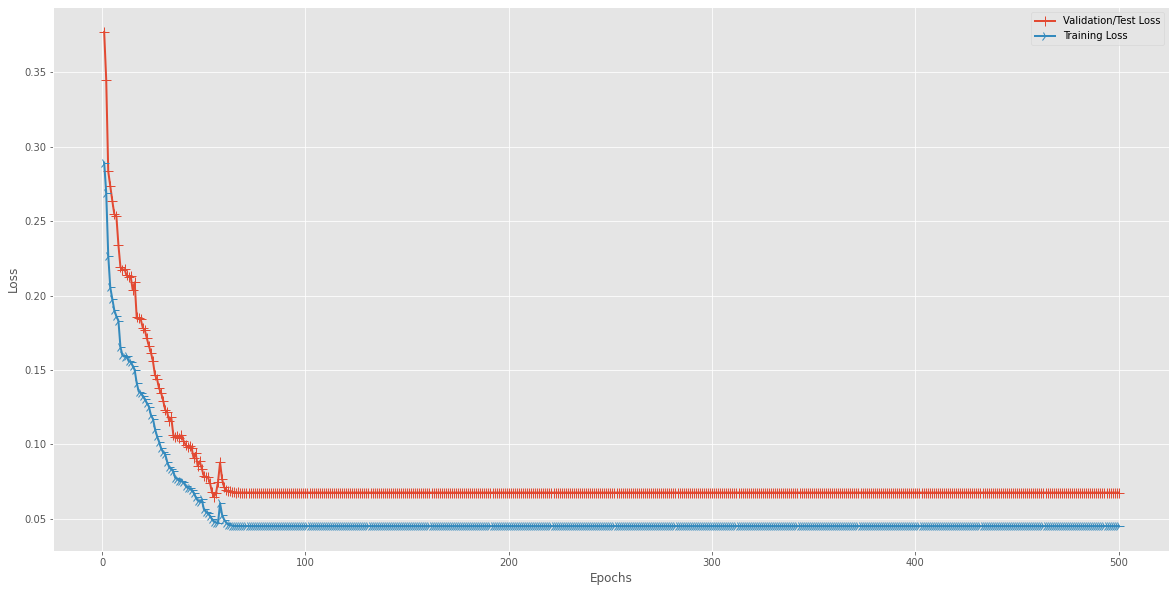

In [10]:
# print(history.history.keys())
# Plotting our loss charts
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.style.use("ggplot")

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('Loss_DAE.png', dpi = 1200)
plt.show()

#### Validation

In [11]:
validation_noise ="/home/kashraf/fall2021_coursework/Neural Nets/Assignment5/documents_denoising_dataset/document_denoising_dataset/test/"
validation_clean = "/home/kashraf/fall2021_coursework/Neural Nets/Assignment5/documents_denoising_dataset/document_denoising_dataset/test_clean/"
noisy_names=os.listdir(validation_noise)
clean_names=os.listdir(validation_clean)
# print(clean_names)

noisy=[]
clean=[]
for file in noisy_names:
    img=cv2.imread(validation_noise+file)
    img=cv2.resize(img, img_shape)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    noisy.append(img)
    
for file in clean_names:
    img=cv2.imread(validation_clean+file)
    
    img=cv2.resize(img, img_shape)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clean.append(img)
noisy=np.array(noisy)/255.
clean=np.array(clean[:72])/255.

noisy = noisy.reshape(-1, img_shape[0]*img_shape[0])
clean = clean.reshape(-1, img_shape[0]*img_shape[0])
print("Clean image shape: ",clean.shape)
print("noisy shape: ",noisy.shape)

Clean image shape:  (72, 3136)
noisy shape:  (72, 3136)


In [15]:
from skimage.measure import compare_ssim
preds=autoencoder.predict(noisy)
ssim_score= compare_ssim(preds,clean,multichannel=True)
loss_mse= autoencoder.evaluate(preds,clean)
print("CAE MSE validation loss:", loss_mse)
print("CAE SSIM score:", ssim_score)

3/3 [==============================] - 0s 894us/step - loss: 0.1026
CAE MSE validation loss: 0.10261932760477066
CAE SSIM score: 0.2585891084666922


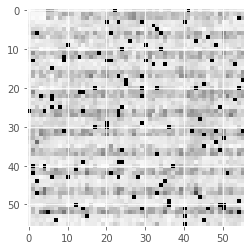

In [16]:
predicted=preds[0].reshape(56,56)
# predicted=cv2.resize(predicted,(224,224))
plt.imshow(predicted,cmap="gray")
plt.show()